# DataSet e bibliotecas a serem usados no projeto

In [38]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import jax as jax
from typing import Callable
from sklearn.model_selection import train_test_split
import time
import timeit
import matplotlib.pyplot as plt

# Carregando o dataset Iris diretamente do scikit-learn
from sklearn.datasets import load_wine
wine = load_wine()

# Convertendo para um DataFrame do Pandas para facilitar a manipulação
data = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                    columns= wine['feature_names'] + ['target'])

# Convertendo para um array JAX se necessário para cálculos futuros
data_jax = jnp.array(data.values)

#imprimir o shape de data
print(data.shape)

# Exibindo as primeiras linhas do DataFrame
print(data.head())

(178, 14)
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_diluted_wines  proline  target  
0

In [2]:
print(data.columns.tolist())

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline', 'target']


# Separação dos dados de treino e teste, normalização e conversão para arrays de JAX

In [12]:
def normalizeData(data):
    #Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
    means = jnp.mean(data, axis=0)
    normalizedData = data - means

    # dataMin = jnp.min(data, axis=0)
    # dataMax = jnp.max(data, axis=0)
    
    # normalizedData = (data - dataMin) / (dataMax - dataMin)
    
    return normalizedData

# Separando dados de treino e de teste
features = data.columns.tolist()[:-1]
x = data[[feature for feature in features]]  
y = data['target']  
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# Convertendo para arrays compatíveis com JAX:
xTrain = normalizeData(jnp.array(xTrain))
xTest = normalizeData(jnp.array(xTest))
yTrain = jnp.array(yTrain)
yTest = jnp.array(yTest)

# Definição de funções que usaremos ao longo da tarefa: knn, pca, medidas de distância e medidas de eficácia do algoritmo

In [4]:
def norm1(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=1)

def norm2(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=2)

def normInf(x:jnp.ndarray, y:jnp.ndarray):
    return jnp.linalg.norm(x - y, ord=jnp.inf)

def getMetric(metricId:str) -> float:
    match metricId:
        case 'norm1':
            _metric = norm1
        case 'norm2':
            _metric = norm2
        case 'normInf':
            _metric = normInf

    return _metric
    

In [15]:
def pca(data:jnp.ndarray, numComponents:int, svd=True) -> jnp.ndarray:
    """
    A partir de um conjunto de dados, retorna a matriz de projeção para as k componentes principais.

    Args:
        data (jnp.ndaaray): Dados para reduzir dimensionalidade.
        numComponents (int): Número de componentes desejadas na projeção.

    Returns:
        jnp.ndarray: Matriz de projeção.
    """

   
    #Normalizando os dados: subtração da média de cada feature e mapeando para o intervalo [0,1]
    # means = jnp.mean(data, axis=0)
    # normalizedData = data - means

    # dataMin = jnp.min(data, axis=0)
    # dataMax = jnp.max(data, axis=0)
    # normalizedData = (data - dataMin) / (dataMax - dataMin)
    
    # Cálculo da matrix de covariância
    # standardDeviation = jnp.std(normalizedData, axis=0)
    # correlationMatrix = jnp.dot(normalizedData.T, normalizedData) / (normalizedData.shape[0] - 1)
    # correlationMatrix = correlationMatrix / jnp.outer(standardDeviation, standardDeviation)
    covarianceMatrix = (1/len(data)) * data.T @ data
    
    if svd:
        # Realizando a decomposição em valores singulares. Vt terá vetores coluna ortogonais.    
        U, S, Vt = jax.scipy.linalg.svd(covarianceMatrix) 
        projectionMatrix = Vt[:numComponents]
    else:
        eigenvalues, eigenvectors = jnp.linalg.eig(covarianceMatrix)  # compute the eigenvalues and eigenvectors
        indices = jnp.argsort(eigenvalues, descending=True)              # sort the eigenvalues
        pcM = jnp.real(eigenvectors[indices][:numComponents])# get the principal components

        # transfM = matrix_1 @ pcM.T    
        projectionMatrix = pcM

    

    return projectionMatrix



In [6]:
def knn(xTrain:jnp.ndarray, yTrain:jnp.ndarray, xTest:jnp.ndarray, k:int, metric:Callable[[jnp.ndarray, jnp.ndarray], float]) -> jnp.ndarray:
    """ Implementa a classificação de um conjunto de dados a partir do algoritmo de K-Nearest Neighbors (KNN).

    Args:
        xTrain (jnp.ndarray): Dados de treino
        yTrain (jnp.ndarray): Labels para os dados de treino
        xTest (jnp.ndarray): Dados de teste
        k (int): Número de vizinhos mais próximos usados para a classificação.
        metric (Callable): Função que calcula distância entre dois pontos.

    Returns:
        jnp.ndarray: Array contendo as predições realizadas para o conjunto de dados de teste xTest.
    """
    
    # distances = jax.vmap(lambda test_point: jax.vmap(metric, in_axes=(0, None))(xTrain, test_point))(xTest)    
    distances = jax.vmap(lambda train_point: jax.vmap(metric, in_axes=(None, 0))(train_point, xTest))(xTrain)

    # Sort along axis 0 (the axis representing training points for each test point)
    sorted_indices = jnp.argsort(distances, axis=0)

    # Select the first k indices (the nearest neighbors) for each test point
    nearest_neighbors_indices = sorted_indices[:k, :]

    nearest_labels = yTrain[nearest_neighbors_indices].astype(int)

    # Count occurrences of each class in neighbors
    totalLabels = 3
    class_counts = jax.vmap(lambda neighbors: jnp.bincount(neighbors, minlength=totalLabels, length=3))(nearest_labels.T)
    
    # Get the most common class for each test point
    most_common_classes = jnp.argmax(class_counts, axis=1)
    
    return most_common_classes


# Accuracy calculation
def computeAccuracy(predictions, actualLabels):
    # Compare predictions with actual labels
    correct_predictions = jnp.sum(predictions == actualLabels)
    
    # Calculate accuracy
    accuracy = correct_predictions / actualLabels.size
    
    return accuracy

# Implementação do KNN sem redução de dimensionalidade

In [74]:
accuracy = {}
elapsedTimes = {}
k=5
metrics=['norm1', 'norm2', 'normInf']

for metric in metrics:
    accuracy[metric] = []
    elapsedTimes[metric] = []
    for neighbors in range(1, 13):
            
        distance = getMetric(metric)
        
        startTime = time.time()
        predictions = knn(xTrain, yTrain, xTest, neighbors, distance)
        endTime = time.time()
        
        acc = computeAccuracy(predictions, yTest)
        accuracy[metric].append(acc.item())
        elapsedTimes[metric].append(endTime - startTime)

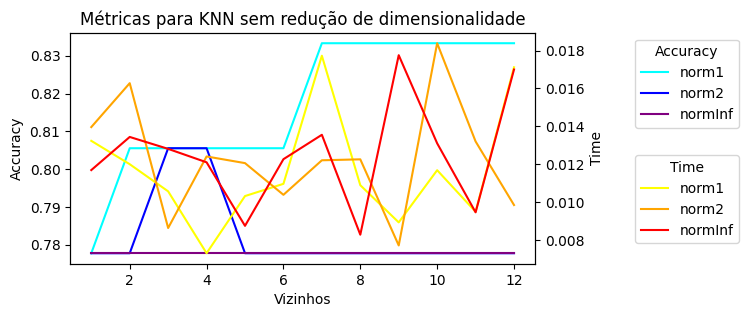

In [82]:
neighbors = range(1, 13)

fig, ax1 = plt.subplots(figsize=(6, 3))
plt.title('Métricas para KNN sem redução de dimensionalidade')

# Plot the first variable
ax1.plot(neighbors, accuracy['norm1'], label='norm1', color='cyan')
ax1.plot(neighbors, accuracy['norm2'], label='norm2', color='blue')
ax1.plot(neighbors, accuracy['normInf'], label='normInf', color='purple')
ax1.set_xlabel('Vizinhos')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second variable
ax2.plot(neighbors, elapsedTimes['norm1'], label='norm1', color='yellow')
ax2.plot(neighbors, elapsedTimes['norm2'], label='norm2', color='orange')
ax2.plot(neighbors, elapsedTimes['normInf'], label='normInf', color='red')
ax2.set_ylabel('Time', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax1.legend(title='Accuracy', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.legend(title='Time', loc='upper left', bbox_to_anchor=(1.2, 0.5))


In [52]:
distance = getMetric('norm1')
k=5

startTime = time.time()
predictions = knn(xTrain, yTrain, xTest, k, distance)
endTime = time.time()
print("elapsed time:", endTime - startTime)

acc = computeAccuracy(predictions, yTest)
acc.item()


elapsed time: 0.01513051986694336


0.9444444179534912

In [8]:
execution_time = timeit.timeit(lambda: knn(xTrain, yTrain, xTest, k, distance), number=100)
print(execution_time)

0.5797233000630513


## Comparação com implementação usando scikit learn para fins de check de sanidade

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Step 3: Create a k-NN classifier
k = 3  # Number of neighbors
knnClassifier = KNeighborsClassifier(n_neighbors=k, metric='manhattan')

# Step 4: Fit the model
knnClassifier.fit(xTrain, yTrain)

# Step 5: Make predictions
predictions = knnClassifier.predict(xTest)

# Step 6: Evaluate the model
accuracy = accuracy_score(yTest, predictions)
accuracy

0.8888888888888888

# Implementação do KNN com redução de dimensionalidade por meio de Principal Component Analysis (PCA)

In [36]:
distance = getMetric('norm1')
k=3
numComponents = 13

useSvd = True

xTrainReducedDim = xTrain @ pca(xTrain, numComponents, svd=useSvd).T 
xTestReducedDim = xTest @ pca(xTest, numComponents, svd=useSvd).T

print(xTrain.shape)
print(xTest.shape)

print(xTrainReducedDim.shape)
print(xTestReducedDim.shape)

startTime = time.time()
predictions = knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance)
endTime = time.time()
print("elapsed time:", endTime - startTime)

acc = computeAccuracy(predictions, yTest)
acc.item()


(142, 13)
(36, 13)
(142, 13)
(36, 13)
elapsed time: 0.014186382293701172


0.8333333134651184

In [78]:
accuracy = {}
elapsedTimes = {}
k=3
numComponents = 13
useSvd = True
metrics=['norm1', 'norm2', 'normInf']

for metric in metrics:
    accuracy[metric] = []
    elapsedTimes[metric] = []
    for nbComponents in range(1, 13):
    
        
        distance = getMetric(metric)
        
        xTrainReducedDim = xTrain @ pca(xTrain, nbComponents, svd=useSvd).T 
        xTestReducedDim = xTest @ pca(xTest, nbComponents, svd=useSvd).T

        startTime = time.time()
        predictions = knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance)
        endTime = time.time()
        
        acc = computeAccuracy(predictions, yTest)
        accuracy[metric].append(acc.item())
        elapsedTimes[metric].append(endTime - startTime)

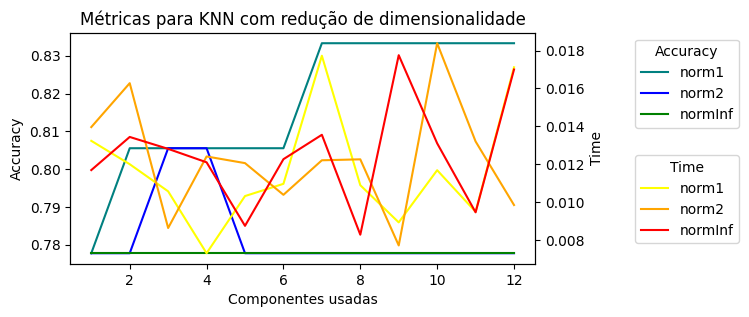

In [86]:
components = range(1, 13)

fig, ax1 = plt.subplots(figsize=(6, 3))
plt.title('Métricas para KNN com redução de dimensionalidade')

# Plot the first variable
ax1.plot(components, accuracy['norm1'], label='norm1', color='teal')
ax1.plot(components, accuracy['norm2'], label='norm2', color='blue')
ax1.plot(components, accuracy['normInf'], label='normInf', color='green')
ax1.set_xlabel('Componentes usadas')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis
ax2 = ax1.twinx()

# Plot the second variable
ax2.plot(components, elapsedTimes['norm1'], label='norm1', color='yellow')
ax2.plot(components, elapsedTimes['norm2'], label='norm2', color='orange')
ax2.plot(components, elapsedTimes['normInf'], label='normInf', color='red')
ax2.set_ylabel('Time', color='black')
ax2.tick_params(axis='y', labelcolor='black')

ax1.legend(title='Accuracy', loc='upper left', bbox_to_anchor=(1.2, 1))
ax2.legend(title='Time', loc='upper left', bbox_to_anchor=(1.2, 0.5))

In [55]:
execution_time = timeit.timeit(lambda: knn(xTrainReducedDim, yTrain, xTestReducedDim, k, distance), number=100)
print(execution_time)

1.2200768999755383


In [ ]:
trainData = jnp.array([[1.0, 2.0], [2.0, 3.0], [3.0, 4.0], [5.0, 6.0]])
trainLabels = jnp.array([0, 0, 1, 1])
testData = jnp.array([[2.5, 3.5], [4.0, 5.0]])

metric = getMetric('norm2')

distances = jax.vmap(lambda test_point: jax.vmap(metric, in_axes=(0, None))(trainData, test_point))(testData)
distances